# Checking Data

In this notebook, I will go through my data. The data is from various sources, see the writeup linked in README.md for details about the data and the setup. getting the libraries and data:

In [15]:
# imports:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import quad
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')

# data - note terrain data is in a shapefile so need geopandas to unpack it
terrain = gpd.read_file('data/terrain/terrain.shp')
# set coordinate system
terrain.crs = {'init': 'espg3857'}
rain = pd.read_csv('data/rain_inflow_data.csv', header=0, parse_dates=[0], index_col=0)
check = pd.read_csv('data/bowston_gauge_data.csv', header=0)

# making the data compatible
check['datetime'] = pd.to_datetime(check['datetime'], dayfirst = True)
check = check.set_index('datetime')
rain.columns = [int(x)-1 for x in rain.columns]

The terrain data gives information about the structure of the network. Rain are the inflows into each network segment. Each value is the average inflow a the 15 minute interval. This data is the output of a different model which I have kinfly been able to use. Check is the flow value of the river measured at a gauge, and is used to check accuracy.

In [16]:
# terrain data - note slopes are negative, and the lack of a width column:
terrain.head()

,DRN_ID,FROMNODE,TONODE,Shape_Leng,Slope,geometry
0,eaew1001000001246737,eaew1002000001227040,eaew1002000001226843,350.402959,-0.0059,"LINESTRING (-311436.612 7250333.355, -311443.5..."
1,eaew1001000001247572,eaew1002000001233647,eaew1002000001233527,102.265036,-0.0500,"LINESTRING (-317160.115 7241700.447, -317159.5..."
2,eaew1001000001247575,eaew1002000001233897,eaew1002000001233647,332.964884,-0.0560,"LINESTRING (-316762.982 7241349.746, -316765.4..."
3,eaew1001000001249305,eaew1002000001228620,eaew1002000001228633,351.081675,-0.0335,"LINESTRING (-314268.224 7248325.191, -314273.9..."
4,eaew1001000001249306,eaew1002000001227872,eaew1002000001228153,354.399622,-0.1018,"LINESTRING (-313701.859 7249348.503, -313701.7..."


## Rain Data

The inflow is given per segment. As the outflow is for the whole network, it is useful to compare the total inflow and the total outflow - these should be simmilar. I am specifically interested in storm Ciara, which occours around the 10th Feb. I am plotting inflow vs outflow - note that the inflow does not take into account how the river network affects the flow. However, over slong timescales these values should be simmilar. It is therefore a good sanity check.

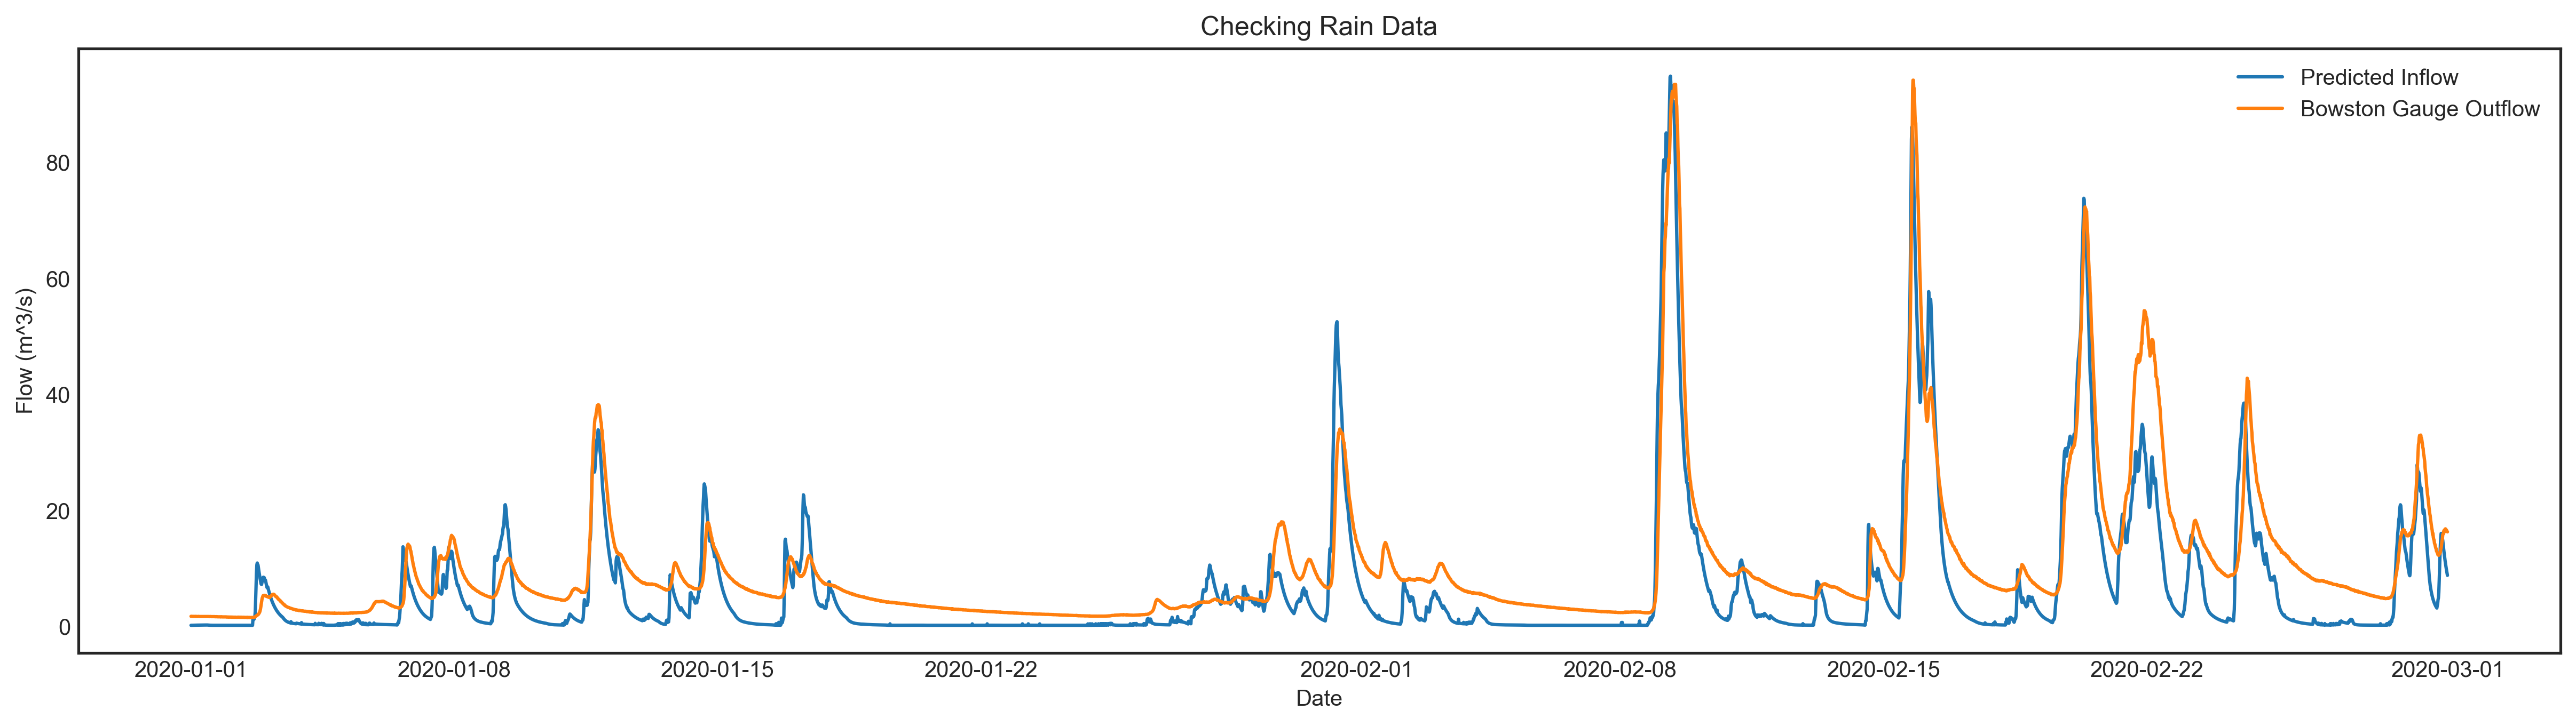

In [17]:
network_inflow = rain.sum(axis=1)
fig, ax = plt.subplots(figsize=(20,5), dpi=300)
ax.plot(network_inflow, label='Predicted Inflow')
ax.plot(check.Flow, label='Bowston Gauge Outflow')
ax.legend()
ax.set(xlabel='Date', ylabel='Flow (m^3/s)', title='Checking Rain Data');

There are significant differences in the data. Most notably, the inputs predict a drastically lower flow than the output suggests. This leads to a large difference in volume. As the output is directly from a gauge reading, while the inputs are the result of a model, I will add the difference to represent a constant baseflow. This also deals with the predicted inflow being negligible whenever there isn't a storm, which is clearly unrealistic for a catchment of this size.

In [31]:
# total volume difference:
total_inflow = sum( network_inflow )
total_outflow = sum( check.Flow )
# note difference is average 15 minute difference
difference = total_outflow - total_inflow
# vol_difference has units of m^3
vol_difference = difference*15*60
print('The total volume diffe`rence is '+str(round(vol_difference))+' m^3.')

The total volume diffe`rence is 19945908 m^3.


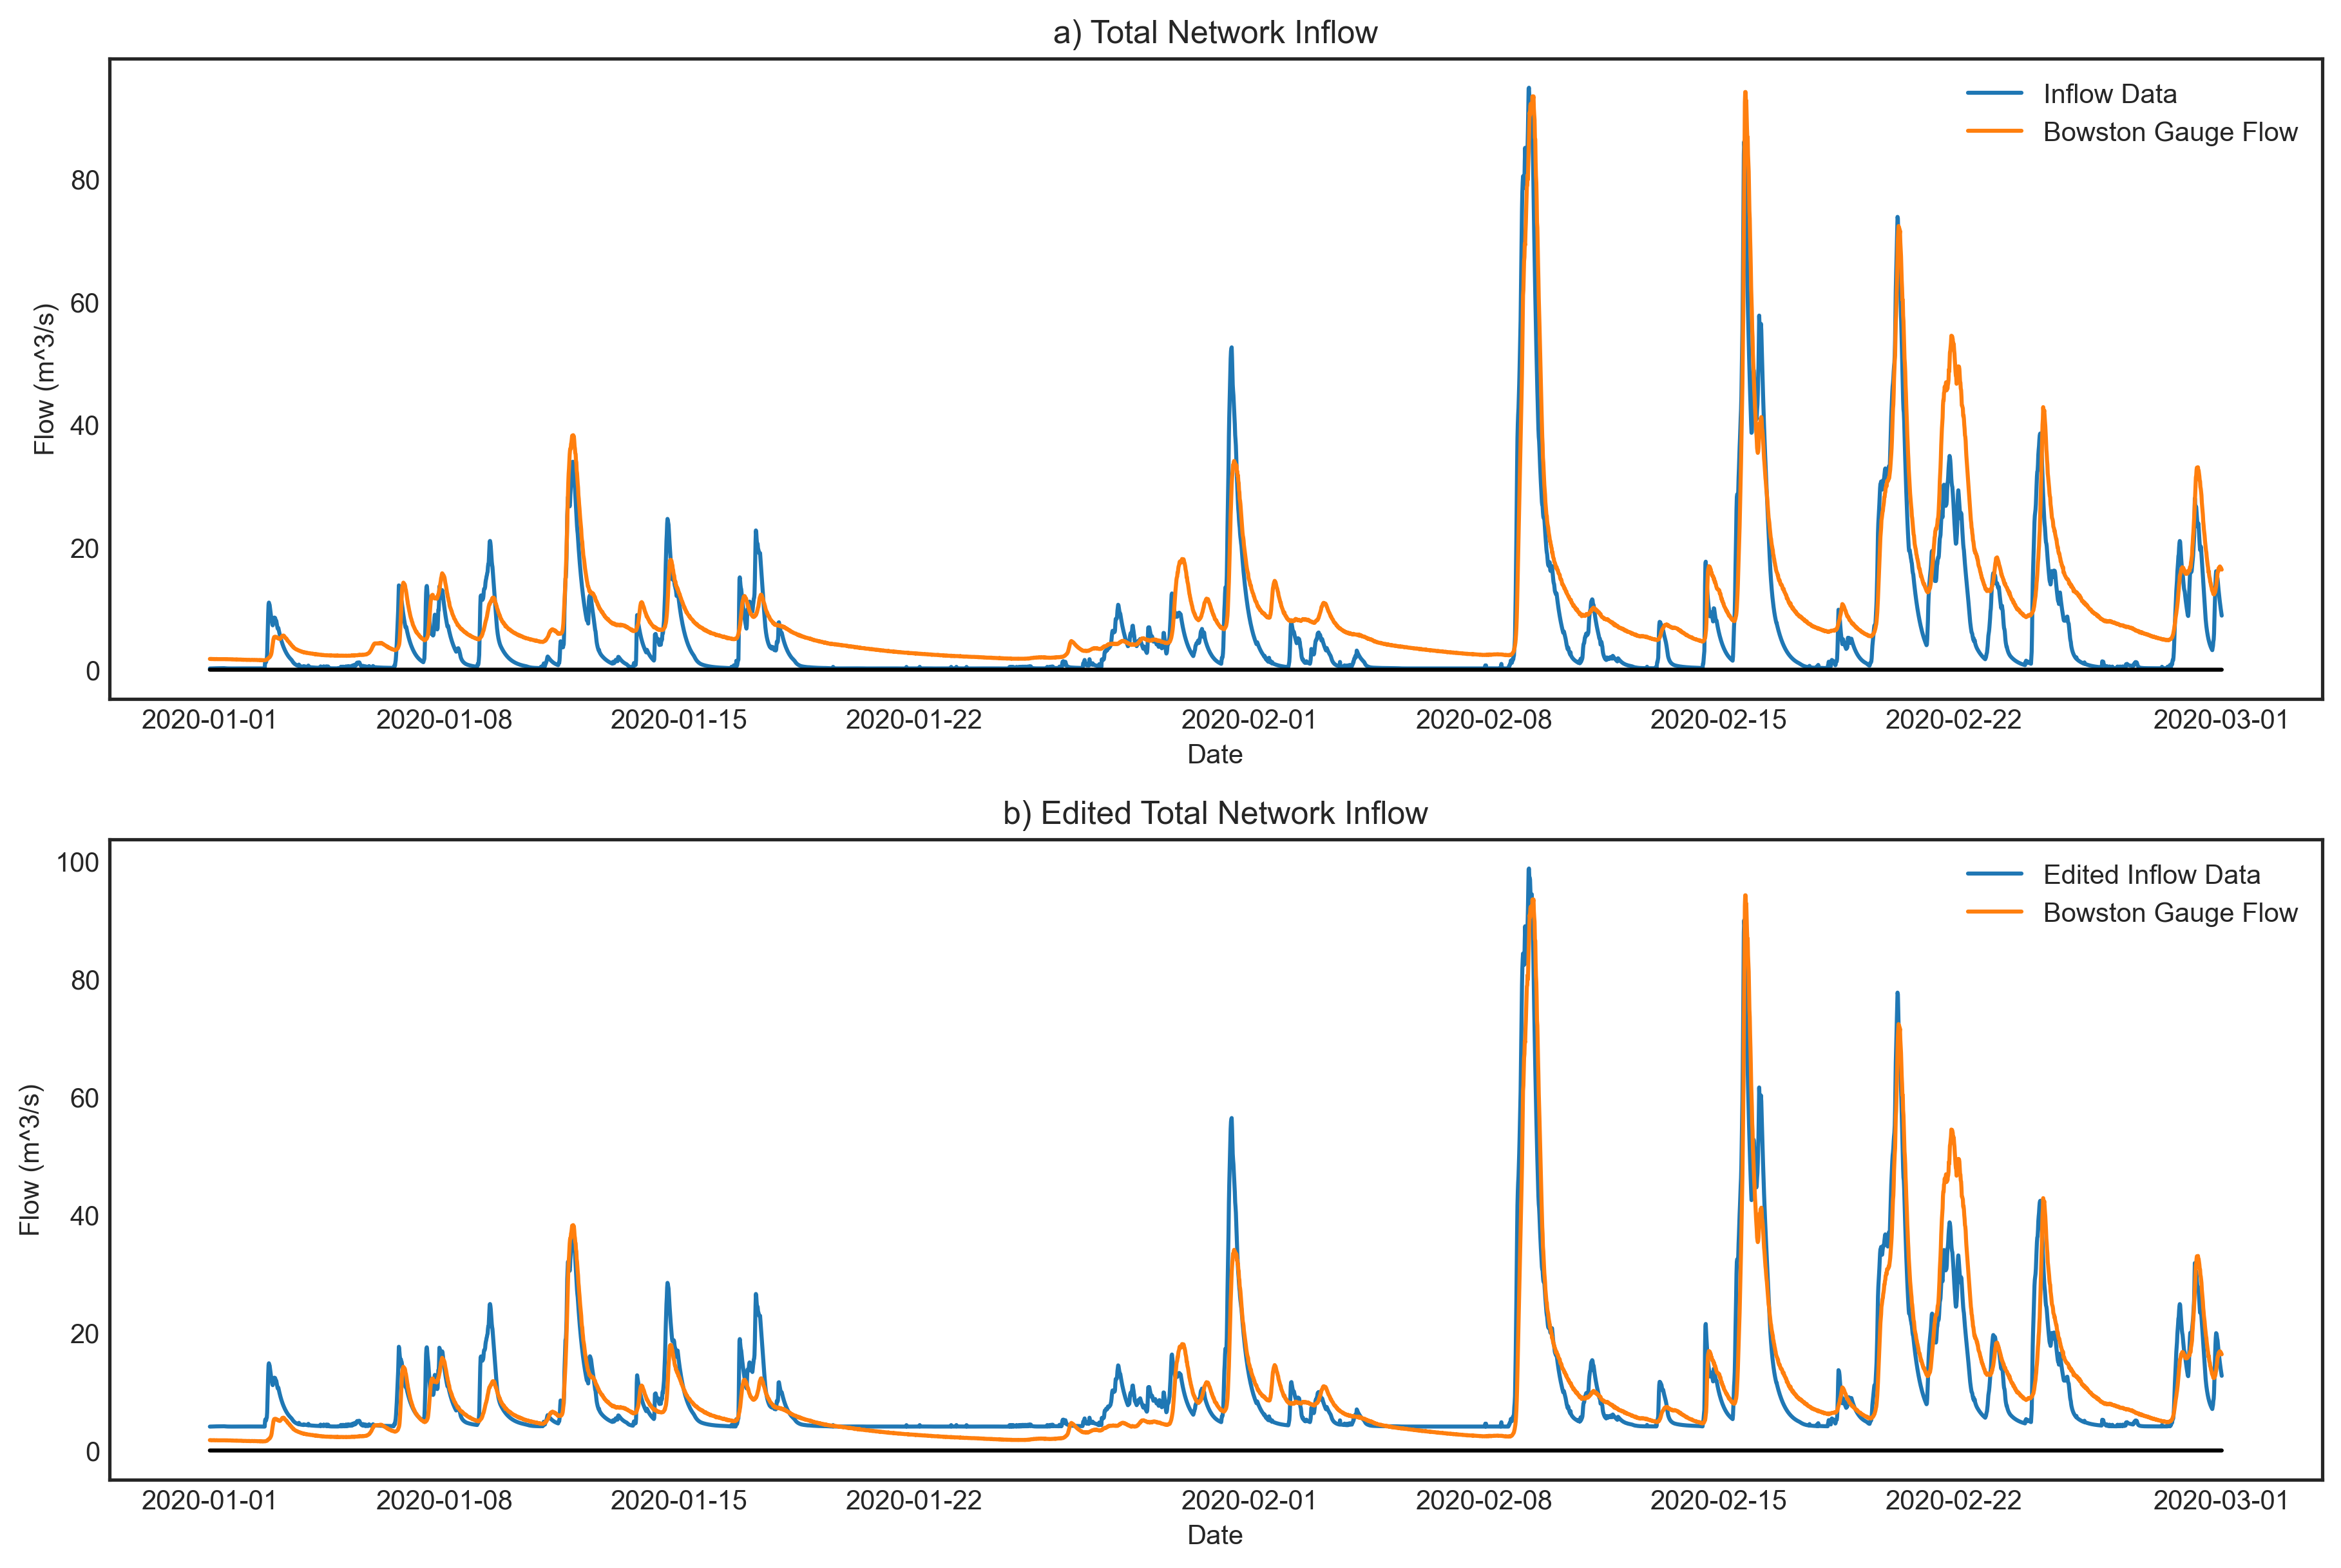

In [42]:
fig, ax = plt.subplots(2, figsize=(12,8),dpi=300, constrained_layout=True)

ax[0].plot(network_inflow, label='Inflow Data')
ax[0].plot(check.Flow, label='Bowston Gauge Flow')
ax[0].legend()
ax[0].plot(check.index, [0 for _ in check.index],'k')
ax[0].set(xlabel='Date', ylabel='Flow (m^3/s)', title='a) Total Network Inflow');

ax[1].plot(edited_inflow, label='Edited Inflow Data')
ax[1].plot(check.Flow, label='Bowston Gauge Flow')
ax[1].legend()
ax[1].plot(check.index, [0 for _ in check.index],'k')
ax[1].set(xlabel='Date', ylabel='Flow (m^3/s)', title='b) Edited Total Network Inflow');

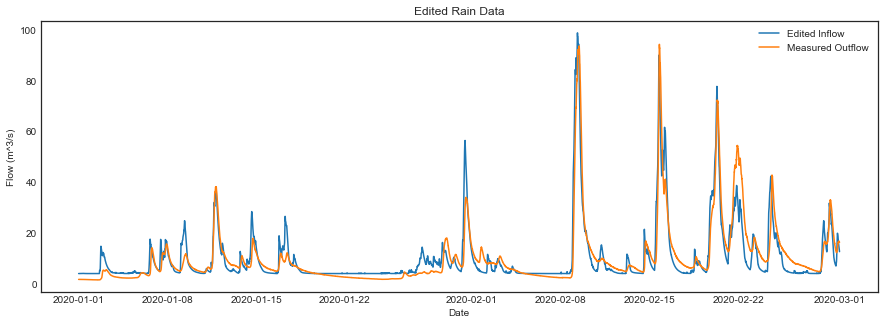

In [19]:
# adding the difference as a uniform baseflow:
diff = difference/len(check.Flow)
edited_inflow =network_inflow + diff

#plotting:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(edited_inflow, label='Edited Inflow')
ax.plot(check.Flow, label='Measured Outflow')
ax.legend()
ax.set(xlabel='Date', ylabel='Flow (m^3/s)', title='Edited Rain Data');

We can plot dofferences, however this is not a completely useful comparison as note there will be some delay between rain entering the model and flow leaving the end - sharp changes during storms mean that it's natural
that there will be some difference.

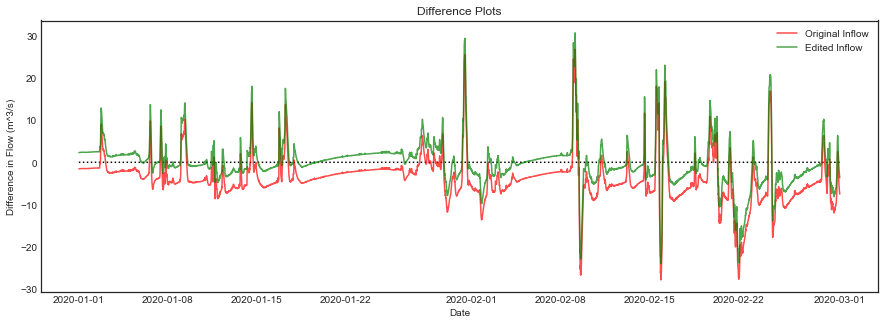

In [6]:
# plotting differences:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(edited_inflow.index, np.zeros(len(check.index)),'k:')
ax.plot(network_inflow-check.Flow, 'r', alpha=0.7, label='Original Inflow')
ax.plot(edited_inflow-check.Flow, 'g', alpha=0.7, label='Edited Inflow')
ax.legend()
ax.set(xlabel='Date', ylabel='Difference in Flow (m^3/s)', title='Difference Plots');

This is far more accurate, as it conserves volume. However, this is just for the sum of the inflows. I am allocating this baseflow based on the ratio of segment length to total network length.

In [7]:
# ratios of lengths:
length_ratio = terrain.Shape_Leng.copy() / terrain.Shape_Leng.sum()

# proportion the constant rain infall along each edge
length_ratio *= diff

# then add these values to all inputs, making new rain data
edited_rain = rain.copy()
for i in edited_rain.columns:
    edited_rain[i] = rain[i]+length_ratio[i]
    
# saving this new data
edited_rain.to_csv('data/edited_rain.csv')

## Network Data

Visualising the network:

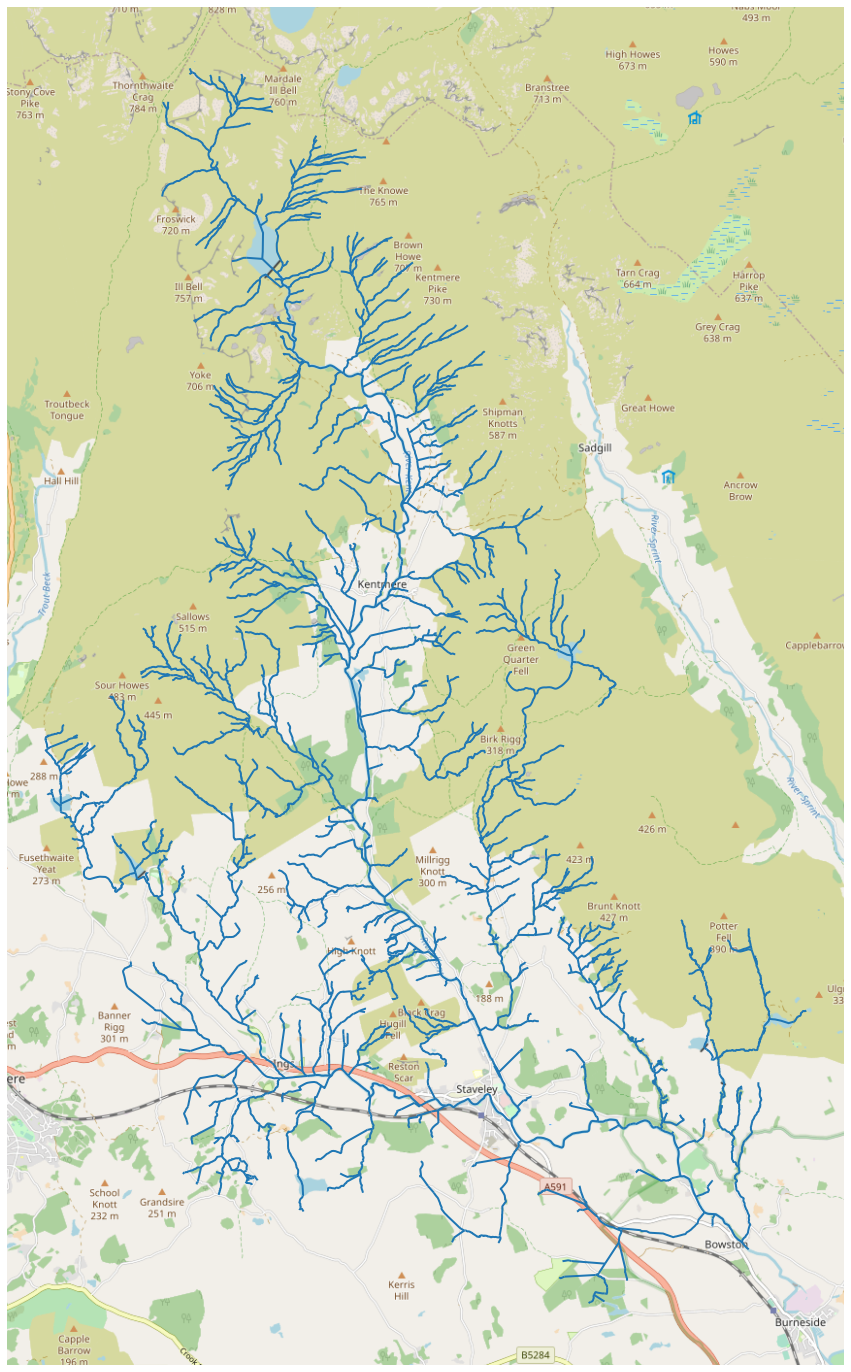

In [8]:
fig, ax = plt.subplots(figsize=(15,25))
ax.axis('off')
terrain.plot(ax=ax, linewidth=2) # geopandas makes this easy
ctx.add_basemap(ax,url=ctx.sources.OSM_A, zoom=13) # basemap from openstreetmap.org

Most notable absent from the given network data are the segment widths. Segment width has a large impact on tdam effectiveness, so it's worth giving this some attantion. I'm using networkx for graph properties.

In [9]:
# find the adjacency matrix using TONODE and FROMONDE identitiers
N = terrain.shape[0]
Adj = np.zeros((N,N)) 
for i in range(N):
    for j in range(N):
        if terrain['TONODE'][i] == terrain['FROMNODE'][j]:
            Adj[i,j]=1
# create directed graph            
graph = nx.convert_matrix.from_numpy_matrix(Adj, create_using=nx.DiGraph())

There is some subtlety here - the data is given as a series of nodes, and the river digraph are 'arrows' connecting these points. The network I am interested in has segments as nodes and an edge from node i to node j if segment i flows directly into segment j.

I have no information about the widths, other than that the final segment has width approximately 15m. There are multiple approaches, two are to scale the widths linearly based on how large its catchment is - for segment i, this is 
$ \sum\limits_{\substack{j \\ P_{ji}\:exists}} l_j $, where $P_{ji}$ is a path from j to i.

In [10]:
# find lengths of paths between edges
graph_lengths = dict(nx.shortest_path_length(graph))
# find distance between a segment and the 'final' segment i.e. lowest
distance = [-max(graph_lengths[i].values()) for i in range(N)]
# order such that every edge's predecessors always appear before it in the list
ordering = tuple(map(int, np.argsort(distance)))

# index of the segments flowing directly into an edge
def in_vertices(i):
    return [edge[0] for edge in graph.in_edges(i)]

# calculating the length measure by summing its own length and those of inflowing segments
length_measure = np.zeros(N)
for i in ordering:
    length_measure[i] = sum([length_measure[j] for j in in_vertices(i)]) + terrain.Shape_Leng[i]   

Define segment widths so that they linearly increase from 0 to 15, based on the proportion of a segment's 'catchment length'.

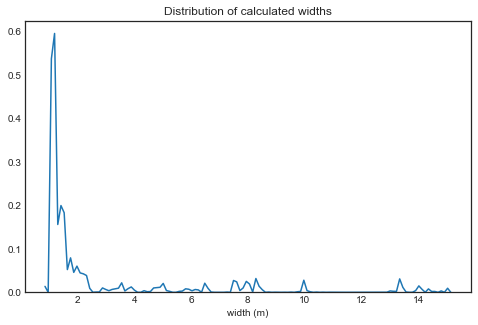

In [11]:
# ratios:
widths = length_measure * 14/max(length_measure) + 1
# visualisig the distribution of widths
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(widths, bw=0.05, ax=ax)
ax.set(xlabel='width (m)', title='Distribution of calculated widths')

# save the widths
np.save(open('data/widths.npy','wb'), widths)

The dams I am interested in are small and could only be built over relatively small width rivers. Also, the model assumes that the length of a segment including a dam is sufficiently large. Here, I'll make an array of segments that have potential to be dammed.

In [12]:
pot_dams = (widths>1.15) & (widths<5) & (terrain.Shape_Leng>20)
np.save(open('data/pot_dams.npy','wb'), pot_dams)

## Smaller Catchment

To make the impact dams have clearer, I'm using a subset of the above network. The choice of segments was done on QGIS, and outputted the DRN_ID values to be used. I'll use the same width values - this code just gets the correct widths for this in the correct order.

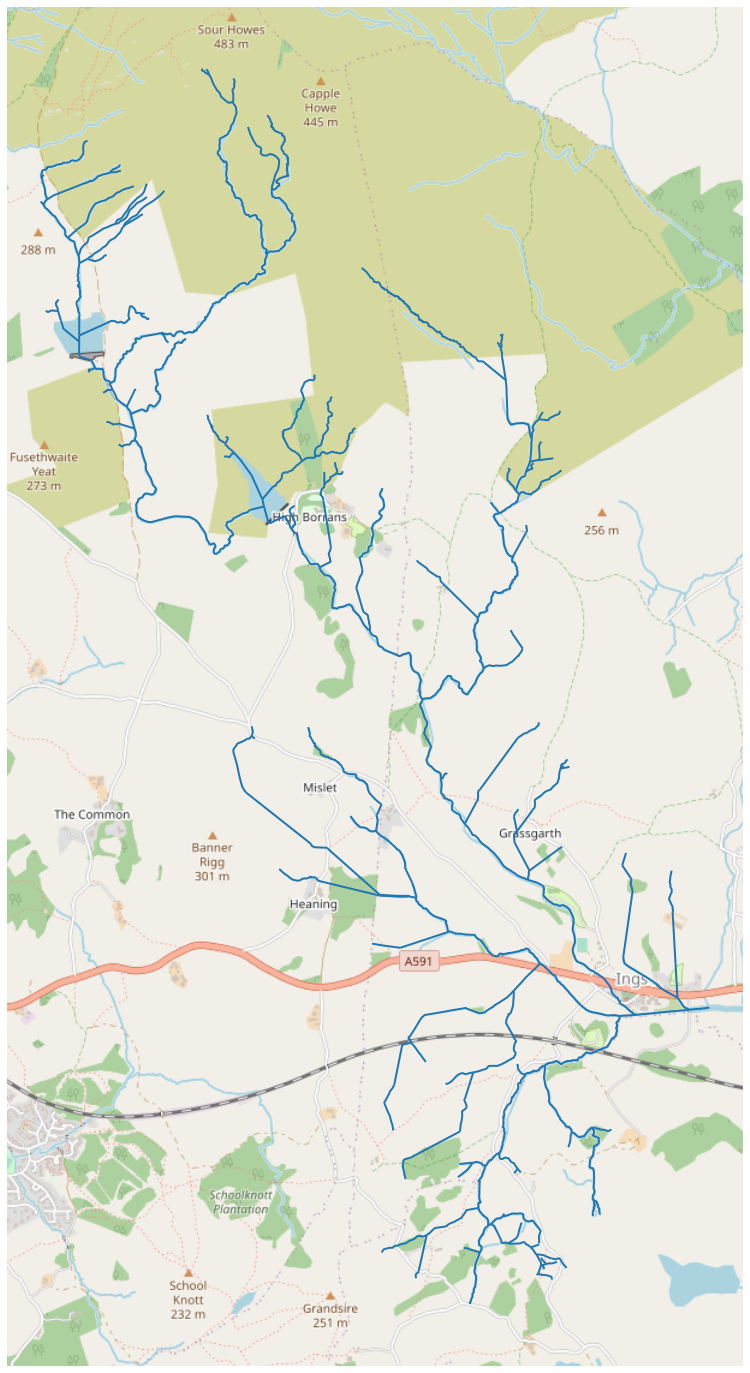

In [13]:
# data - note terrain data is in a shapefile so need geopandas to unpack it
sub_terrain = gpd.read_file('data/sub_terrain/sub_terrain.shp')
sub_terrain.crs = {'init': 'espg3857'}

sub_N = sub_terrain.shape[0]

fig, ax = plt.subplots(figsize=(15,25))
ax.axis('off')
sub_terrain.plot(ax=ax, linewidth=2)
ctx.add_basemap(ax,url=ctx.sources.OSM_A, zoom=14)

In [14]:
sub_widths = np.zeros(sub_N)
for i, name in  enumerate(sub_terrain.DRN_ID):
    # find index of edge in terrain
    sub_widths[i] = widths[ terrain[terrain.DRN_ID == name].index[0] ]
    
# potential dams
sub_pot_dams = [(sub_widths>0.3)&(sub_widths<5)&(sub_terrain.Shape_Leng>20)]
np.save(open('data/sub_pot_dams.npy','wb'), sub_pot_dams)    
    
# save sub_widths
np.save(open('data/sub_widths.npy','wb'), sub_widths)